<h1>First, loading the dataset from kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shahdelshafei","key":"14f5ddafb4294a7aa0668177a33ba201"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d moltean/fruits

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
 99% 3.46G/3.49G [00:57<00:00, 155MB/s]
100% 3.49G/3.49G [00:57<00:00, 65.4MB/s]


In [6]:
!unzip fruits.zip

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_277.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_281.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_285.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_289.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_29.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_33.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_37.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_41.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_45.jpg  
  inflating: fruits-360_original-size/fruits-360-original-size/Validation/Tomato 1/r0_49.j

In [7]:
#The path to the train and the test directories
train_dir="/content/fruits-360_original-size/fruits-360-original-size/Training"
test_dir="/content/fruits-360_original-size/fruits-360-original-size/Test"

In [8]:
#This part is for listing and their paths inside the directory specified
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [9]:
#The coming part is the beginning of the dataset building
#where it's going to contain 2 columns one for the classes and the other is for the images paths
import os
fruits=[]
fruits_image=[]
for i in os.listdir(train_dir):
  for image_filename in os.listdir(os.path.join(train_dir, i)):
    fruits.append(i)
    fruits_image.append(os.path.join(i, image_filename))

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
train_fruits = pd.DataFrame(fruits, columns=["Fruits"])
train_fruits["Fruits Image"] = fruits_image

In [12]:
train_fruits

,Fruits,Fruits Image
0,apple_golden_1,apple_golden_1/r0_208.jpg
1,apple_golden_1,apple_golden_1/r1_50.jpg
2,apple_golden_1,apple_golden_1/r0_0.jpg
3,apple_golden_1,apple_golden_1/r0_204.jpg
4,apple_golden_1,apple_golden_1/r0_178.jpg
...,...,...
29525,apple_hit_1,apple_hit_1/r0_214.jpg
29526,apple_hit_1,apple_hit_1/r0_260.jpg
29527,apple_hit_1,apple_hit_1/r2_64.jpg
29528,apple_hit_1,apple_hit_1/r2_200.jpg


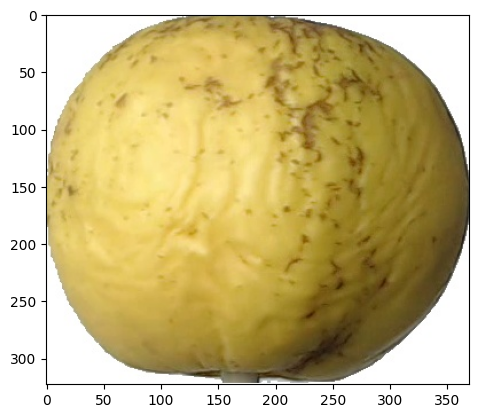

In [13]:
#Showing a sample from the train images
plt.imshow(plt.imread(train_dir + '/' + train_fruits["Fruits Image"][0]))
plt.show()

<h1>Trying to unfreeze some layers

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


# 1. Paths to data

train_dir = "/content/fruits-360_original-size/fruits-360-original-size/Training"
val_dir   = "/content/fruits-360_original-size/fruits-360-original-size/Validation"
test_dir  = "/content/fruits-360_original-size/fruits-360-original-size/Test"


# 2. Image specifications

IMG_SIZE = (224, 224)
BATCH_SIZE = 32


# 3. Data generators with augmentation

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = train_gen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)
val_data = val_gen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)
test_data = test_gen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical", shuffle=False
)


# 4. Load VGG16 base

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze initially


# 5. Add custom classification head

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(train_data.num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=output)


# 6. Initial training (frozen base)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

print("🔹 Training with frozen base model...")
model.fit(train_data, validation_data=val_data, epochs=3)


# 7. Fine-tuning: unfreezing last block

print("🔹 Fine-tuning last block...")

set_trainable = False
for layer in base_model.layers:
    if layer.name.startswith("block5"):  # unfreeze last block
        set_trainable = True
    layer.trainable = set_trainable

# Recompile with small LR
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Fine-tune
model.fit(train_data, validation_data=val_data, epochs=3)


# 8. Evaluate on test data

test_loss, test_acc = model.evaluate(test_data)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")


Found 29530 images belonging to 91 classes.
Found 14769 images belonging to 91 classes.
Found 14680 images belonging to 91 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🔹 Training with frozen base model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
923/923 ━━━━━━━━━━━━━━━━━━━━ 506s 534ms/step - accuracy: 0.0299 - loss: 15.0736 - val_accuracy: 0.3258 - val_loss: 3.3804
Epoch 2/3
923/923 ━━━━━━━━━━━━━━━━━━━━ 473s 513ms/step - accuracy: 0.1705 - loss: 7.1767 - val_accuracy: 0.6443 - val_loss: 1.1913
Epoch 3/3
923/923 ━━━━━━━━━━━━━━━━━━━━ 477s 517ms/step - accuracy: 0.3386 - loss: 4.0666 - val_accuracy: 0.8194 - val_loss: 0.5464
🔹 Fine-tuning last block...
Epoch 1/3
923/923 ━━━━━━━━━━━━━━━━━━━━ 500s 534ms/step - accuracy: 0.6007 - loss: 1.4683 - val_accuracy: 0.9825 - val_loss: 0.0776
Epoch 2/3
923/923 ━━━━━━━━━━━━━━━━━━━━ 488s 528ms/step - accuracy: 0.8571 - loss: 0.4486 - val_accuracy: 0.9935 - val_loss: 0.0264
Epoch 3/3
923/923 ━━━━━━━━━━━━━━━━━━━━ 483s 523ms/step - accuracy: 0.9293 - loss: 0.2119 - val_accuracy: 0.9961 - val_loss: 0.0134
459/459 ━━━━━━━━━━━━━━━━━━━━ 92s 200ms/step - accuracy: 0.9971 - loss: 0.0098
✅ Test Accuracy: 99.62%


459/459 ━━━━━━━━━━━━━━━━━━━━ 82s 177ms/step


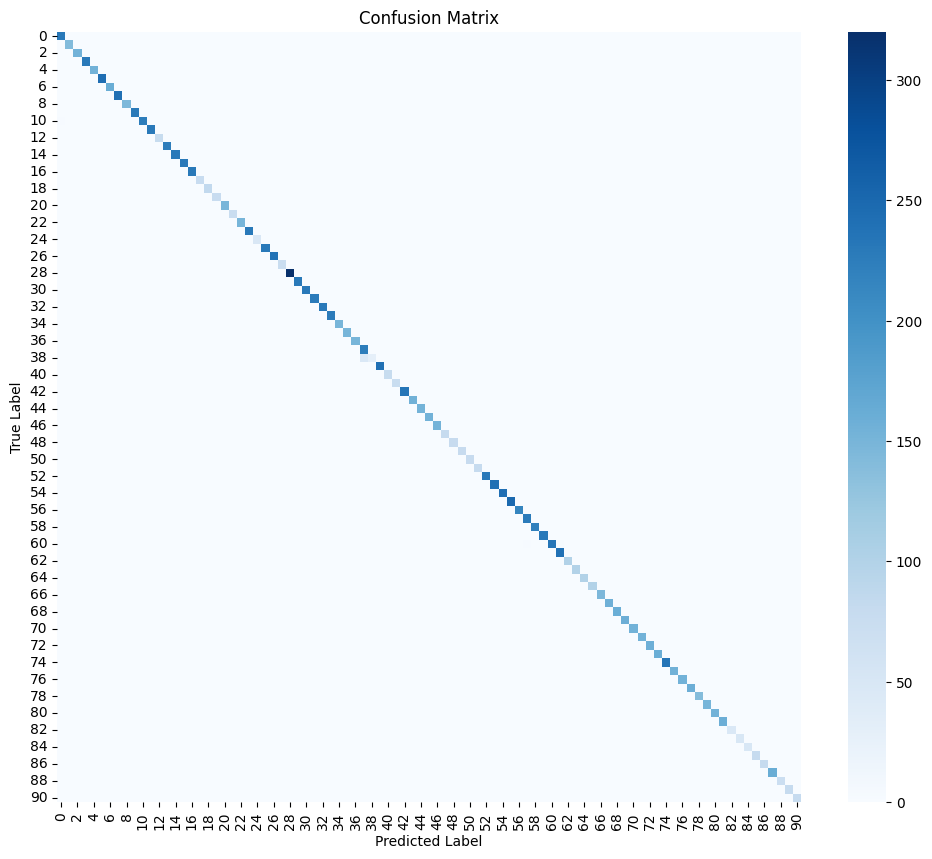

                           precision    recall  f1-score   support

                 Apple 10       0.99      1.00      1.00       231
                 Apple 11       1.00      1.00      1.00       142
                 Apple 12       1.00      1.00      1.00       154
                 Apple 13       1.00      1.00      1.00       231
                 Apple 14       1.00      1.00      1.00       154
                 Apple 17       1.00      1.00      1.00       243
                 Apple 18       1.00      1.00      1.00       162
                 Apple 19       1.00      1.00      1.00       241
                  Apple 5       1.00      1.00      1.00       146
                  Apple 7       1.00      1.00      1.00       229
                  Apple 8       1.00      0.99      1.00       228
                  Apple 9       1.00      1.00      1.00       231
             Apple Core 1       1.00      1.00      1.00        78
       Apple Red Yellow 2       1.00      1.00      1.00     

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)  # predicted labels
y_true = test_data.classes           # true labels

# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report (precision, recall, f1-score)
print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys()))

In [17]:
# Save the trained model
model.save("fruits_recognition_model.keras")